# Dataset
[Dataset Link](https://huggingface.co/datasets/ccdv/arxiv-summarization?utm_source=chatgpt.com)

In [ ]:
!pip install -q datasets transformers spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is incompatible.
torch 2.6.0+cu124 req

# Load Dataset and Inspect

In [ ]:
from datasets import load_dataset

# Load the dataset (train split only for now)
dataset = load_dataset("ccdv/arxiv-summarization", split="train")

# View the structure of the first sample
print(dataset[0].keys())
print("Sample Article:", dataset[0]['article'][:500])  # Preview only
print("Sample Abstract:", dataset[0]['abstract'])

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00001-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00002-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00003-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00004-of-00015.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00005-of-00015.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00006-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00007-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00008-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00009-of-00015.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00010-of-00015.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00011-of-00015.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

train-00012-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00013-of-00015.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00014-of-00015.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/105M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203037 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6440 [00:00<?, ? examples/s]

dict_keys(['article', 'abstract'])
Sample Article: additive models @xcite provide an important family of models for semiparametric regression or classification . some reasons for the success of additive models are their increased flexibility when compared to linear or generalized linear models and their increased interpretability when compared to fully nonparametric models . 
 it is well - known that good estimators in additive models are in general less prone to the curse of high dimensionality than good estimators in fully nonparametric models
Sample Abstract: additive models play an important role in semiparametric statistics . 
 this paper gives learning rates for regularized kernel based methods for additive models . 
 these learning rates compare favourably in particular in high dimensions to recent results on optimal learning rates for purely nonparametric regularized kernel based quantile regression using the gaussian radial basis function kernel , provided the assumption of an

# Sentence Segmentation & Named Entity Extraction

In [ ]:
import spacy

# Load spaCy model for sentence splitting and NER
nlp = spacy.load("en_core_web_sm")

# Load once globally
nlp_ner = spacy.load("en_core_web_sm")
nlp_sent = spacy.blank("en")
nlp_sent.add_pipe("sentencizer")

def preprocess_article(text, max_chars=50000, use_entities=True):
    text = text[:max_chars]

    if use_entities:
        doc = next(nlp_ner.pipe([text]))
        entities = list(set(
            ent.text.strip()
            for ent in doc.ents
            if ent.label_ in {'PERSON', 'ORG', 'GPE', 'DATE', 'WORK_OF_ART'}
        ))
    else:
        doc = next(nlp_sent.pipe([text]))
        entities = []

    # Filter better sentences
    sentences = [
        sent.text.strip() for sent in doc.sents
        if len(sent.text.strip()) > 40 and not sent.text.strip().startswith('*') and not sent.text.strip().isdigit()
    ]

    return sentences, entities

# Graph Construction with DGL

In [ ]:
pip install -q torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu124

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 638.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.4/883.4 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
pip install -q dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import dgl
import torch
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


## build graph

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Build and Inspect the Graph

In [ ]:
# !pip install sentence-transformers==2.2.2

In [ ]:
# # Install accelerate
!pip install -q accelerate==0.29.3

# # Install transformers
!pip install -q transformers==4.39.3

# # Install sentence-transformers
# !pip install sentence-transformers==2.2.2

# # Install bertopic
# !pip install bertopic==0.16.0

# # Ensure spaCy and its model are installed/downloaded
# !pip install spacy
# !python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.39.3 which is incompatible.


In [ ]:
!pip uninstall -y sentence-transformers

Found existing installation: sentence-transformers 3.4.1
Uninstalling sentence-transformers-3.4.1:
  Successfully uninstalled sentence-transformers-3.4.1


In [ ]:
!pip install -q sentence-transformers==2.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install -q bertopic==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
import torch
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Device Capability: {torch.cuda.get_device_capability(0)}")

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap # Import UMAP for custom model
import hdbscan # Import HDBSCAN for custom model (good practice for BERTopic)
import numpy as np # For potential min/max operations

# --- NEW: Prepare a larger collection of sentences for BERTopic ---
all_sentences_for_bertopic = []
num_articles_to_process = 200 # Adjust this number!

print(f"Collecting sentences from {num_articles_to_process} articles...")
for i in range(num_articles_to_process):
    if i >= len(dataset):
        print(f"Reached end of dataset at article {i}. Stopping collection.")
        break
    if i % 100 == 0 and i != 0: # Print progress every 100 articles after the first
        print(f"Processing article {i}...")
    article_text = dataset[i]['article']
    sents, _ = preprocess_article(article_text)
    all_sentences_for_bertopic.extend(sents)

print(f"Total sentences collected for BERTopic: {len(all_sentences_for_bertopic)}")

if len(all_sentences_for_bertopic) < 50:
    print("WARNING: Insufficient sentences collected for meaningful topic modeling. Consider increasing `num_articles_to_process`.")

# --- Rest of your BERTopic code, now using `all_sentences_for_bertopic` ---

# Embed the sentences
# SentenceTransformer will automatically use GPU if available and properly configured with PyTorch-CUDA
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Embedding sentences (this might take a while for large datasets)...")
# The encoding process will now run on GPU if available
# sentence_embeddings = sbert_model.encode(all_sentences_for_bertopic, show_progress_bar=True)
from tqdm import tqdm

batch_size = 256
sentence_embeddings = []
for i in tqdm(range(0, len(all_sentences_for_bertopic), batch_size)):
    batch = all_sentences_for_bertopic[i:i+batch_size]
    sentence_embeddings.extend(sbert_model.encode(batch))

PyTorch CUDA available: True
CUDA Device Name: Tesla P100-PCIE-16GB
CUDA Device Capability: (6, 0)


2025-07-13 18:00:07.333834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752429607.524676      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752429607.583246      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Processing article 100...
Total sentences collected for BERTopic: 35173


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding sentences (this might take a while for large datasets)...


  0%|          | 0/138 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  1%|          | 1/138 [00:00<01:05,  2.10it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  1%|▏         | 2/138 [00:00<00:39,  3.44it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  2%|▏         | 3/138 [00:00<00:35,  3.82it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  3%|▎         | 4/138 [00:01<00:31,  4.29it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  4%|▎         | 5/138 [00:01<00:29,  4.54it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  4%|▍         | 6/138 [00:01<00:27,  4.77it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  5%|▌         | 7/138 [00:01<00:26,  4.89it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  6%|▌         | 8/138 [00:01<00:25,  5.15it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  7%|▋         | 9/138 [00:01<00:24,  5.24it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  7%|▋         | 10/138 [00:02<00:24,  5.15it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  8%|▊         | 11/138 [00:02<00:24,  5.15it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  9%|▊         | 12/138 [00:02<00:24,  5.25it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  9%|▉         | 13/138 [00:02<00:23,  5.34it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 10%|█         | 14/138 [00:02<00:23,  5.17it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 11%|█         | 15/138 [00:03<00:22,  5.55it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▏        | 16/138 [00:03<00:22,  5.40it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▏        | 17/138 [00:03<00:22,  5.30it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 13%|█▎        | 18/138 [00:03<00:25,  4.77it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 14%|█▍        | 19/138 [00:03<00:25,  4.70it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 14%|█▍        | 20/138 [00:04<00:24,  4.91it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 15%|█▌        | 21/138 [00:04<00:23,  5.00it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 16%|█▌        | 22/138 [00:04<00:22,  5.13it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 17%|█▋        | 23/138 [00:04<00:21,  5.44it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 17%|█▋        | 24/138 [00:04<00:21,  5.41it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 18%|█▊        | 25/138 [00:05<00:19,  5.75it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 19%|█▉        | 26/138 [00:05<00:20,  5.52it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 20%|█▉        | 27/138 [00:05<00:19,  5.67it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 20%|██        | 28/138 [00:05<00:20,  5.39it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 21%|██        | 29/138 [00:05<00:20,  5.37it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 22%|██▏       | 30/138 [00:05<00:20,  5.35it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 22%|██▏       | 31/138 [00:06<00:20,  5.15it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 23%|██▎       | 32/138 [00:06<00:20,  5.20it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 24%|██▍       | 33/138 [00:06<00:19,  5.25it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▍       | 34/138 [00:06<00:19,  5.26it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 35/138 [00:06<00:20,  4.98it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 26%|██▌       | 36/138 [00:07<00:21,  4.80it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 27%|██▋       | 37/138 [00:07<00:21,  4.63it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 28%|██▊       | 38/138 [00:07<00:20,  5.00it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 28%|██▊       | 39/138 [00:07<00:18,  5.35it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 29%|██▉       | 40/138 [00:07<00:17,  5.59it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 30%|██▉       | 41/138 [00:08<00:17,  5.58it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 30%|███       | 42/138 [00:08<00:16,  5.80it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 31%|███       | 43/138 [00:08<00:16,  5.66it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 32%|███▏      | 44/138 [00:08<00:16,  5.84it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 33%|███▎      | 45/138 [00:08<00:15,  5.95it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 33%|███▎      | 46/138 [00:08<00:15,  6.07it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 34%|███▍      | 47/138 [00:09<00:15,  5.86it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 35%|███▍      | 48/138 [00:09<00:15,  5.88it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 36%|███▌      | 49/138 [00:09<00:15,  5.61it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 36%|███▌      | 50/138 [00:09<00:16,  5.44it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 37%|███▋      | 51/138 [00:09<00:15,  5.55it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 52/138 [00:10<00:16,  5.35it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 53/138 [00:10<00:15,  5.40it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 39%|███▉      | 54/138 [00:10<00:16,  5.13it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 40%|███▉      | 55/138 [00:10<00:14,  5.61it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 41%|████      | 56/138 [00:10<00:14,  5.59it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 41%|████▏     | 57/138 [00:10<00:14,  5.65it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 42%|████▏     | 58/138 [00:11<00:13,  5.86it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 43%|████▎     | 59/138 [00:11<00:13,  5.79it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 43%|████▎     | 60/138 [00:11<00:13,  5.72it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 44%|████▍     | 61/138 [00:11<00:13,  5.58it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 45%|████▍     | 62/138 [00:11<00:13,  5.55it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 46%|████▌     | 63/138 [00:11<00:13,  5.53it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 46%|████▋     | 64/138 [00:12<00:13,  5.65it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 47%|████▋     | 65/138 [00:12<00:12,  5.80it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 48%|████▊     | 66/138 [00:12<00:11,  6.02it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 49%|████▊     | 67/138 [00:12<00:12,  5.90it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 49%|████▉     | 68/138 [00:12<00:11,  6.01it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 69/138 [00:13<00:12,  5.73it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 51%|█████     | 70/138 [00:13<00:11,  5.73it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 51%|█████▏    | 71/138 [00:13<00:11,  5.76it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 52%|█████▏    | 72/138 [00:13<00:11,  5.59it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 53%|█████▎    | 73/138 [00:13<00:11,  5.56it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 54%|█████▎    | 74/138 [00:13<00:11,  5.44it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 54%|█████▍    | 75/138 [00:14<00:10,  5.73it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 55%|█████▌    | 76/138 [00:14<00:10,  5.77it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 56%|█████▌    | 77/138 [00:14<00:10,  5.88it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 57%|█████▋    | 78/138 [00:14<00:10,  5.48it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 57%|█████▋    | 79/138 [00:14<00:10,  5.66it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 58%|█████▊    | 80/138 [00:14<00:10,  5.59it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 59%|█████▊    | 81/138 [00:15<00:10,  5.62it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 59%|█████▉    | 82/138 [00:15<00:09,  5.70it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 60%|██████    | 83/138 [00:15<00:09,  5.57it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 61%|██████    | 84/138 [00:15<00:09,  5.66it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▏   | 85/138 [00:15<00:10,  5.26it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▏   | 86/138 [00:16<00:10,  5.16it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 63%|██████▎   | 87/138 [00:16<00:09,  5.26it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 64%|██████▍   | 88/138 [00:16<00:09,  5.48it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 64%|██████▍   | 89/138 [00:16<00:09,  5.44it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 65%|██████▌   | 90/138 [00:16<00:08,  5.33it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 66%|██████▌   | 91/138 [00:16<00:08,  5.52it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 67%|██████▋   | 92/138 [00:17<00:08,  5.64it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 67%|██████▋   | 93/138 [00:17<00:07,  5.78it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 68%|██████▊   | 94/138 [00:17<00:07,  5.87it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 69%|██████▉   | 95/138 [00:17<00:07,  5.68it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 70%|██████▉   | 96/138 [00:17<00:07,  5.84it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 70%|███████   | 97/138 [00:18<00:07,  5.65it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 71%|███████   | 98/138 [00:18<00:07,  5.57it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 72%|███████▏  | 99/138 [00:18<00:07,  5.48it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 72%|███████▏  | 100/138 [00:18<00:07,  5.30it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 73%|███████▎  | 101/138 [00:18<00:07,  5.03it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 74%|███████▍  | 102/138 [00:19<00:07,  5.10it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 75%|███████▍  | 103/138 [00:19<00:06,  5.20it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 75%|███████▌  | 104/138 [00:19<00:06,  5.18it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 76%|███████▌  | 105/138 [00:19<00:06,  5.18it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 77%|███████▋  | 106/138 [00:19<00:05,  5.35it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 78%|███████▊  | 107/138 [00:19<00:05,  5.53it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 78%|███████▊  | 108/138 [00:20<00:05,  5.21it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 79%|███████▉  | 109/138 [00:20<00:05,  5.58it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 80%|███████▉  | 110/138 [00:20<00:04,  5.77it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 80%|████████  | 111/138 [00:20<00:04,  5.88it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 81%|████████  | 112/138 [00:20<00:04,  6.13it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 82%|████████▏ | 113/138 [00:20<00:04,  6.11it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 83%|████████▎ | 114/138 [00:21<00:04,  5.92it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 83%|████████▎ | 115/138 [00:21<00:04,  5.70it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 84%|████████▍ | 116/138 [00:21<00:03,  5.92it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 85%|████████▍ | 117/138 [00:21<00:03,  5.93it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 86%|████████▌ | 118/138 [00:21<00:03,  5.70it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 86%|████████▌ | 119/138 [00:21<00:03,  5.67it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 87%|████████▋ | 120/138 [00:22<00:03,  5.35it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 88%|████████▊ | 121/138 [00:22<00:03,  5.51it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 88%|████████▊ | 122/138 [00:22<00:02,  5.45it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 89%|████████▉ | 123/138 [00:22<00:02,  5.55it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 90%|████████▉ | 124/138 [00:22<00:02,  5.64it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 91%|█████████ | 125/138 [00:23<00:02,  5.37it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 91%|█████████▏| 126/138 [00:23<00:02,  5.47it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 92%|█████████▏| 127/138 [00:23<00:02,  5.43it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 93%|█████████▎| 128/138 [00:23<00:01,  5.53it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 93%|█████████▎| 129/138 [00:23<00:01,  5.18it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 94%|█████████▍| 130/138 [00:24<00:01,  5.13it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 95%|█████████▍| 131/138 [00:24<00:01,  5.16it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 96%|█████████▌| 132/138 [00:24<00:01,  4.87it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 96%|█████████▋| 133/138 [00:24<00:00,  5.05it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 97%|█████████▋| 134/138 [00:24<00:00,  5.00it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 98%|█████████▊| 135/138 [00:25<00:00,  5.12it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 99%|█████████▊| 136/138 [00:25<00:00,  5.54it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

 99%|█████████▉| 137/138 [00:25<00:00,  5.70it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 138/138 [00:25<00:00,  5.42it/s]


In [ ]:
# Configure UMAP and HDBSCAN for BERTopic
umap_n_neighbors = max(2, min(15, len(all_sentences_for_bertopic) - 1))
umap_model = umap.UMAP(n_neighbors=umap_n_neighbors,
                       n_components=5,
                       min_dist=0.0,
                       random_state=42)

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=50,
                                metric='euclidean',
                                prediction_data=True)

print("Fitting BERTopic model (this might take a while)...")
topic_model = BERTopic(embedding_model=sbert_model,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       calculate_probabilities=True,
                       verbose=True)

# topics, probs = topic_model.fit_transform(all_sentences_for_bertopic, embeddings=sentence_embeddings)
import numpy as np

sentence_embeddings = np.array(sentence_embeddings)  # Convert list to array
topics, probs = topic_model.fit_transform(all_sentences_for_bertopic, embeddings=sentence_embeddings)

print("\nBERTopic ran successfully!")
print(f"Number of topics found: {len(topic_model.get_topic_info()) - 1}")

print("\nTop 10 Topics:")
print(topic_model.get_topic_info().head(11))

if 0 in topic_model.get_topic_info()['Topic'].values:
    print("\nWords for Topic 0:")
    print(topic_model.get_topic(0))
else:
    print("\nTopic 0 does not exist (possibly all data are outliers or no clear topics).")

# Optional: Visualize topics if you have enough data and want to confirm
# from bertopic import plotting
# if len(topics) > 1:
#    fig = topic_model.visualize_topics()
#    fig.show()

2025-07-13 18:03:12,980 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Fitting BERTopic model (this might take a while)...


2025-07-13 18:04:10,222 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:04:10,225 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-13 18:04:34,096 - BERTopic - Cluster - Completed ✓
2025-07-13 18:04:34,115 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-07-13 18:04:35,193 - BERTopic - Representation - Completed ✓



BERTopic ran successfully!
Number of topics found: 116

Top 10 Topics:
    Topic  Count                                  Name  \
0      -1  13768                      -1_the_of_in_and   
1       0   1261                      0_phys_apj_ph_et   
2       1   1047            1_this_section_results_sec   
3       2    952                      2_then_if_let_we   
4       3    761         3_stars_cluster_star_clusters   
5       4    718  4_galaxies_galaxy_redshift_redshifts   
6       5    575               5_map_category_chain_ar   
7       6    511               6_xcite_in_results_been   
8       7    449    7_permutation_rauzy_geodesic_veech   
9       8    440  8_orbits_orbit_bifurcation_attractor   
10      9    435            9_spectra_spectrum_gl_band   

                                       Representation  \
0      [the, of, in, and, is, to, for, we, with, are]   
1   [phys, apj, ph, et, al, hep, doibase, arxiv, l...   
2   [this, section, results, sec, our, paper, we, ...   
3  

In [ ]:
from bertopic import plotting
if len(topics) > 1: # Only visualize if more than just the outlier topic
    fig = topic_model.visualize_topics()
    fig.show()

    # Other useful visualizations:
    fig = topic_model.visualize_barchart(top_n_topics=10)
    fig.show()
    fig = topic_model.visualize_heatmap()
    fig.show()

# Add topic nodes and sentence-to-topic edges

# corefers_with edges between sentence nodes and discourse_follows edges (sequential sentence connections)

In [ ]:
# neuralcoref was built for spaCy 2.x, we can still use a fork that works for spaCy 3.x
!pip install git+https://github.com/huggingface/neuralcoref.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/huggingface/neuralcoref.git to /tmp/pip-req-build-1xh4xlr5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/neuralcoref.git /tmp/pip-req-build-1xh4xlr5
  Resolved https://github.com/huggingface/neuralcoref.git to commit 60338df6f9b0a44a6728b442193b7c66653b0731
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# import spacy
# import coreferee

# # Load coreference model (do once)
# nlp = spacy.load("en_coreference_web_trf")
# nlp.add_pipe("coreferee")

# def build_graph_with_coref_and_discourse(sentences, entities, topic_ids=None):
#     import torch
#     import dgl
#     from sklearn.feature_extraction.text import TfidfVectorizer
#     from sklearn.metrics.pairwise import cosine_similarity

#     num_sents = len(sentences)
#     num_ents = len(entities)
#     num_topics = len(set(topic_ids)) if topic_ids else 0

#     # --- Edge containers
#     edge_dict = {
#         ('sentence', 'mentions', 'entity'): ([], []),
#         ('sentence', 'belongs_to', 'topic'): ([], []),
#         ('sentence', 'corefers_with', 'sentence'): ([], []),
#         ('sentence', 'discourse_follows', 'sentence'): ([], [])
#     }

#     # --- Sentence-to-entity edges
#     for s_idx, sent in enumerate(sentences):
#         for e_idx, ent in enumerate(entities):
#             if ent.lower() in sent.lower():
#                 edge_dict[('sentence', 'mentions', 'entity')][0].append(s_idx)
#                 edge_dict[('sentence', 'mentions', 'entity')][1].append(e_idx)

#     # --- Sentence-to-topic edges
#     if topic_ids:
#         topic_map = {t: i for i, t in enumerate(sorted(set(topic_ids)))}
#         for s_idx, t_id in enumerate(topic_ids):
#             if t_id != -1:
#                 topic_idx = topic_map[t_id]
#                 edge_dict[('sentence', 'belongs_to', 'topic')][0].append(s_idx)
#                 edge_dict[('sentence', 'belongs_to', 'topic')][1].append(topic_idx)

#     # --- Co-reference edges
#     doc = nlp(" ".join(sentences))
#     token_to_sent = {token.i: i for i, s in enumerate(doc.sents) for token in s}

#     if doc._.has_coref:
#         for chain in doc._.coref_chains:
#             mentions = chain.get_mentions()
#             sent_indices = list(set(
#                 token_to_sent.get(m.start)
#                 for m in mentions if token_to_sent.get(m.start) is not None
#             ))
#             for i in range(len(sent_indices)):
#                 for j in range(i + 1, len(sent_indices)):
#                     a, b = sent_indices[i], sent_indices[j]
#                     edge_dict[('sentence', 'corefers_with', 'sentence')][0] += [a, b]
#                     edge_dict[('sentence', 'corefers_with', 'sentence')][1] += [b, a]

#     # --- Discourse edges (sequential)
#     for i in range(num_sents - 1):
#         edge_dict[('sentence', 'discourse_follows', 'sentence')][0] += [i, i + 1]
#         edge_dict[('sentence', 'discourse_follows', 'sentence')][1] += [i + 1, i]

#     # --- Graph init
#     node_dict = {'sentence': num_sents, 'entity': num_ents}
#     if topic_ids:
#         node_dict['topic'] = num_topics

#     # Filter empty edge types
#     graph_data = {
#         etype: (torch.tensor(src), torch.tensor(dst))
#         for etype, (src, dst) in edge_dict.items()
#         if src and dst
#     }

#     g = dgl.heterograph(graph_data, num_nodes_dict=node_dict)
#     return g

In [ ]:
def build_graph_with_topics(sentences, entities, precomputed_topics=None):
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    import torch
    import dgl

    # TF-IDF for sentence similarity
    vectorizer = TfidfVectorizer(max_features=300)
    tfidf_matrix = vectorizer.fit_transform(sentences)
    sim_matrix = cosine_similarity(tfidf_matrix)

    num_sentences = len(sentences)
    num_entities = len(entities)

    sentence_sim_src = []
    sentence_sim_dst = []
    sent_ent_src = []
    sent_ent_dst = []

    # Sentence-to-sentence edges
    threshold = 0.2
    for i in range(num_sentences):
        for j in range(num_sentences):
            if i != j and sim_matrix[i][j] > threshold:
                sentence_sim_src.append(i)
                sentence_sim_dst.append(j)

    # Sentence-to-entity edges
    for sent_idx, sentence in enumerate(sentences):
        for ent_idx, entity in enumerate(entities):
            if entity in sentence:
                sent_ent_src.append(sent_idx)
                sent_ent_dst.append(num_sentences + ent_idx)

    graph_data = {}

    if sentence_sim_src:
        graph_data[('sentence', 'similar_to', 'sentence')] = (
            torch.tensor(sentence_sim_src, dtype=torch.int32),
            torch.tensor(sentence_sim_dst, dtype=torch.int32)
        )

    if sent_ent_src:
        graph_data[('sentence', 'mentions', 'entity')] = (
            torch.tensor(sent_ent_src, dtype=torch.int32),
            torch.tensor(sent_ent_dst, dtype=torch.int32)
        )

    # Sentence-to-topic edges
    sent_topic_src = []
    sent_topic_dst = []
    topic_set = []
    topic_id_map = {}

    if precomputed_topics is not None:
        topic_set = sorted(set(t for t in precomputed_topics if t != -1))
        topic_id_map = {topic_id: idx for idx, topic_id in enumerate(topic_set)}
        for sent_idx, topic_id in enumerate(precomputed_topics):
            if topic_id != -1:
                topic_idx = topic_id_map[topic_id]
                sent_topic_src.append(sent_idx)
                sent_topic_dst.append(num_sentences + num_entities + topic_idx)

        if sent_topic_src:
            graph_data[('sentence', 'belongs_to', 'topic')] = (
                torch.tensor(sent_topic_src, dtype=torch.int32),
                torch.tensor(sent_topic_dst, dtype=torch.int32)
            )

    print(f"Sent-Sent edges: {len(sentence_sim_src)}")
    print(f"Sent-Ent edges: {len(sent_ent_src)}")
    print(f"Sent-Topic edges: {len(sent_topic_src)}")
    print(f"Unique topics found: {len(topic_set)}")

    if not graph_data:
        raise ValueError("Graph has no edges.")

    g = dgl.heterograph(graph_data)

    return g, sentences, entities, topic_set

In [ ]:
# ✅ Combine multiple articles for better topic matching
combined_text = "\n".join(dataset[i]['article'] for i in range(200))  # ← try 20 or even 50

# ✅ Preprocess the combined article text
sentences, entities = preprocess_article(combined_text)

# ✅ Get topic assignments using the trained BERTopic model
document_topics, _ = topic_model.transform(sentences)

# ✅ Build the heterogeneous graph with sentence-entity-topic structure
graph, sent_nodes, ent_nodes, topic_ids = build_graph_with_topics(
    sentences,
    entities,
    precomputed_topics=document_topics
)

# ✅ Inspect graph structure
print("\n--- Graph Structure ---")
print(graph)
print("Node types:", graph.ntypes)
print("Edge types:", graph.etypes)

# ✅ Optional: check sent-topic edge count
if ('sentence', 'belongs_to', 'topic') in graph.canonical_etypes:
    print(f"✅ Sent-Topic edges: {graph.num_edges(('sentence', 'belongs_to', 'topic'))}")
else:
    print("❌ No Sent-Topic edges created.")

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-07-13 18:04:49,708 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:05,080 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:05,081 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:05,108 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:05,355 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:05,356 - BERTopic - Cluster - Completed ✓


Sent-Sent edges: 7834
Sent-Ent edges: 633
Sent-Topic edges: 180
Unique topics found: 20

--- Graph Structure ---
Graph(num_nodes={'entity': 453, 'sentence': 280, 'topic': 473},
      num_edges={('sentence', 'belongs_to', 'topic'): 180, ('sentence', 'mentions', 'entity'): 633, ('sentence', 'similar_to', 'sentence'): 7834},
      metagraph=[('sentence', 'topic', 'belongs_to'), ('sentence', 'entity', 'mentions'), ('sentence', 'sentence', 'similar_to')])
Node types: ['entity', 'sentence', 'topic']
Edge types: ['belongs_to', 'mentions', 'similar_to']
✅ Sent-Topic edges: 180


In [ ]:
print("Assigned topics:", set(document_topics))

Assigned topics: {0, 1, 2, 5, 6, 8, 10, 12, 13, 18, 22, 23, 26, 27, 30, 37, 51, 53, 72, 92, -1}


In [ ]:
# topics, probs = topic_model.fit_transform(sentences)
# Transform individual document using global BERTopic
document_topics, _ = topic_model.transform(sentences)

print("Topics assigned:", topics)
print("Unique topics (excluding -1):", set(t for t in topics if t != -1))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-07-13 18:05:05,981 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:06,111 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:06,112 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:06,139 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:06,389 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:06,390 - BERTopic - Cluster - Completed ✓


Topics assigned: [53, -1, 53, 53, 53, 53, 53, 53, 53, 53, -1, 1, -1, 53, 53, 5, 53, -1, -1, 53, -1, -1, 26, 5, -1, 2, -1, 53, -1, 1, -1, -1, -1, -1, -1, -1, 23, 23, 1, 53, 53, 53, 1, 53, -1, -1, -1, 53, -1, 72, -1, -1, 2, -1, 6, -1, -1, -1, 6, 23, -1, 1, -1, -1, 53, -1, -1, -1, -1, 53, 53, 53, 53, 23, -1, -1, 18, 23, 23, 23, 23, 23, 53, 23, 53, 53, -1, -1, 6, -1, -1, 53, 53, 53, 53, 53, 53, 72, 6, 95, 53, 6, 6, -1, -1, 23, 53, -1, -1, -1, 53, 53, 23, 23, -1, 6, -1, -1, 22, 5, -1, -1, 2, 53, -1, 2, 53, -1, 53, 53, 1, -1, -1, 51, 51, 51, 51, 37, 37, -1, 1, 51, 51, 51, 51, 51, 51, 27, 6, -1, 6, 6, 12, 51, -1, 13, 6, 6, -1, -1, 92, 30, 30, -1, -1, -1, -1, 50, 51, -1, -1, -1, -1, 51, 51, 51, -1, 51, -1, -1, 2, -1, -1, -1, -1, 51, -1, 30, -1, -1, -1, 2, -1, -1, -1, 92, -1, -1, -1, -1, -1, 51, -1, 51, 51, -1, -1, -1, -1, -1, -1, -1, -1, 51, 51, 51, 51, 6, 2, 51, 6, 6, 51, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, -1, 8, 8, 8, 8, 1, 8, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 1, 8

In [ ]:
import pickle

with open("bertopic_model.pkl", "wb") as f:
    pickle.dump(topic_model, f)

np.save("sentence_embeddings.npy", sentence_embeddings)

# Graph Encoding

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import HeteroGraphConv, GraphConv

# Graph Encoder for Heterogeneous Graph
class HeteroGraphEncoder(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, rel_names):
        super().__init__()
        # Define two-layer HeteroGraphConv
        self.layer1 = HeteroGraphConv({
            rel: GraphConv(in_feats, hidden_feats)
            for rel in rel_names
        }, aggregate='mean')

        self.layer2 = HeteroGraphConv({
            rel: GraphConv(hidden_feats, out_feats)
            for rel in rel_names
        }, aggregate='mean')

    def forward(self, g, inputs):
        # inputs is a dictionary of {ntype: feature_tensor}
        h = self.layer1(g, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.layer2(g, h)
        return h

In [ ]:
# 1. Define input features (e.g., use TF-IDF vectors or random init)
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=300)
sentence_feats = vectorizer.fit_transform(sent_nodes).toarray()
sentence_feats = torch.tensor(sentence_feats, dtype=torch.float32)

# Optional: init entity/topic features as zeros or random
entity_feats = torch.randn(graph.num_nodes('entity'), 300)
topic_feats = torch.randn(graph.num_nodes('topic'), 300)

# 2. Combine into dictionary
features = {
    'sentence': sentence_feats,
    'entity': entity_feats,
    'topic': topic_feats
}

# 3. Instantiate the model
rel_names = list(graph.etypes)
model = HeteroGraphEncoder(in_feats=300, hidden_feats=128, out_feats=64, rel_names=rel_names)

# 4. Forward pass to get updated node embeddings
model.eval()  # Disable dropout/batchnorm for inference
with torch.no_grad():
    node_embeddings = model(graph, features)

# 5. Extract sentence node embeddings for summary ranking
sentence_embeddings = node_embeddings['sentence']
print("Sentence Embeddings Shape:", sentence_embeddings.shape)

Sentence Embeddings Shape: torch.Size([280, 64])


In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch

class MultiLevelGraphAttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.sentence_attn = nn.Linear(embed_dim, 1)
        self.entity_attn = nn.Linear(embed_dim, 1)
        self.topic_attn = nn.Linear(embed_dim, 1)

        self.entity_proj = nn.Linear(300, embed_dim)
        self.topic_proj = nn.Linear(300, embed_dim)

        # Learnable fusion weights
        self.raw_weights = nn.Parameter(torch.tensor([1.0, 1.0, 1.0]))  # [α, β, γ]

    def dense_adj_from_edges(self, g, etype, src_size, dst_size):
        src, dst = g.edges(etype=etype)
        adj = torch.zeros((src_size, dst_size), device=src.device)
        adj[src, dst] = 1
        return adj

    def forward(self, sentence_embs, entity_embs, topic_embs, graph, attention_breakdown=False):
        sent_scores = self.sentence_attn(sentence_embs).squeeze(1)

        entity_embs_proj = self.entity_proj(entity_embs)
        topic_embs_proj = self.topic_proj(topic_embs)

        # Entity attention
        if ('sentence', 'mentions', 'entity') in graph.canonical_etypes:
            adj_se = self.dense_adj_from_edges(graph, ('sentence', 'mentions', 'entity'),
                                               graph.num_nodes('sentence'), graph.num_nodes('entity'))
            ent_context = adj_se @ entity_embs_proj
            ent_scores = self.entity_attn(ent_context).squeeze(1)
        else:
            ent_scores = torch.zeros_like(sent_scores)

        # Topic attention
        if ('sentence', 'belongs_to', 'topic') in graph.canonical_etypes:
            adj_st = self.dense_adj_from_edges(graph, ('sentence', 'belongs_to', 'topic'),
                                               graph.num_nodes('sentence'), graph.num_nodes('topic'))
            topic_context = adj_st @ topic_embs_proj
            topic_scores = self.topic_attn(topic_context).squeeze(1)
        else:
            topic_scores = torch.zeros_like(sent_scores)

        weights = F.softmax(self.raw_weights, dim=0)
        alpha, beta, gamma = weights

        final_scores = alpha * sent_scores + beta * ent_scores + gamma * topic_scores

        if attention_breakdown:
            return final_scores, {
                'sentence': sent_scores.detach().cpu(),
                'entity': ent_scores.detach().cpu(),
                'topic': topic_scores.detach().cpu(),
                'weights': weights.detach().cpu()
            }

        return final_scores

In [ ]:
# # Instantiate ML-GAP
# mlgap_scorer = MultiLevelGraphAttentionPooling(embed_dim=64)
# mlgap_scorer.eval()

# with torch.no_grad():
#     importance_scores = mlgap_scorer(
#         sentence_embs=node_embeddings['sentence'],  # ✅ use only sentence embeddings
#         entity_embs=features['entity'],             # ✅ entity features (300-dim)
#         topic_embs=features['topic'],               # ✅ topic features (300-dim)
#         graph=graph
#     )

# # Select top-ranked sentences
# top_k = 5
# top_indices = torch.topk(importance_scores, k=top_k).indices
# top_indices_sorted = sorted(top_indices.tolist())

# # Generate final summary
# summary_sentences = [sent_nodes[i] for i in top_indices_sorted]

# import re
# def clean_sentence(text):
#     text = re.sub(r'@xmath\d+', '', text)
#     text = re.sub(r'@xcite', '', text)
#     text = re.sub(r'\s+', ' ', text)
#     return text.strip()

# cleaned_summary = [clean_sentence(sent) for sent in summary_sentences]

# # Display output
# for i, sent in enumerate(cleaned_summary, 1):
#     print(f"{i}. {sent}")

In [ ]:
# Install ROUGE scorer (only once needed)
!pip install -q rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done


In [ ]:
attention_data = []

In [ ]:
from rouge_score import rouge_scorer
from statistics import mean
from tqdm import tqdm
import torch
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_sentence(text):
    text = re.sub(r'@xmath\d+', '', text)
    text = re.sub(r'@xcite', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# ROUGE evaluator
rouge_eval = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# ML-GAP model in eval mode
mlgap_scorer = MultiLevelGraphAttentionPooling(embed_dim=64)
mlgap_scorer.eval()

# TF-IDF vectorizer for sentence features
vectorizer = TfidfVectorizer(max_features=300)
vectorizer.fit([" ".join(preprocess_article(dataset[i]['article'])[0]) for i in range(50)])

# Initialize metrics and storage
rouge1_f, rouge2_f, rougel_f = [], [], []
attention_data = []  # 🔍 for attention visualization
num_docs_to_eval = 20

# --- Evaluation loop ---
for i in tqdm(range(num_docs_to_eval)):
    article = dataset[i]['article']
    reference = clean_sentence(dataset[i]['abstract'])

    sents, ents = preprocess_article(article)
    if len(sents) < 5:
        continue

    doc_topics, _ = topic_model.transform(sents)
    g, sent_nodes, ent_nodes, topic_ids = build_graph_with_topics(sents, ents, precomputed_topics=doc_topics)

    sent_feats_np = vectorizer.transform(sent_nodes).toarray()
    if sent_feats_np.shape[1] < 300:
        pad_width = 300 - sent_feats_np.shape[1]
        sent_feats_np = np.pad(sent_feats_np, ((0, 0), (0, pad_width)), mode='constant')
    sent_feats = torch.tensor(sent_feats_np, dtype=torch.float32)

    ent_feats = torch.randn(g.num_nodes('entity'), 300)
    topic_feats = torch.randn(g.num_nodes('topic'), 300)
    feats = {'sentence': sent_feats, 'entity': ent_feats, 'topic': topic_feats}

    # --- Forward pass with attention breakdown ---
    with torch.no_grad():
        node_embeds = model(g, feats)['sentence']
        scores, parts = mlgap_scorer(
            sentence_embs=node_embeds,
            entity_embs=feats['entity'],
            topic_embs=feats['topic'],
            graph=g,
            attention_breakdown=True
        )

        top_idx = torch.topk(scores, k=5).indices
        top_idx_sorted = sorted(top_idx.tolist())
        summary_sents = [clean_sentence(sent_nodes[j]) for j in top_idx_sorted]
        generated_summary = " ".join(summary_sents)

        # Print per-sentence attention for summary
        print(f"\n🔍 Attention Breakdown for Document {i + 1}:")
        print(f"Learned weights — alpha: {parts['weights'][0]:.4f}, beta: {parts['weights'][1]:.4f}, gamma: {parts['weights'][2]:.4f}")
        for j in top_idx_sorted:
            print(f"- {clean_sentence(sent_nodes[j])}")
            print(f"  Sentence: {parts['sentence'][j]:.4f} | Entity: {parts['entity'][j]:.4f} | Topic: {parts['topic'][j]:.4f}")

        # 🔻 Save full attention values for visualization
        attention_data.append({
            "doc_id": i,
            "sentence_texts": [clean_sentence(s) for s in sent_nodes],
            "sentence_scores": parts['sentence'].cpu().numpy().tolist(),
            "entity_scores": parts['entity'].cpu().numpy().tolist(),
            "topic_scores": parts['topic'].cpu().numpy().tolist(),
            "weights": [x.item() for x in parts['weights']]
        })

    # --- ROUGE ---
    results = rouge_eval.score(reference, generated_summary)
    rouge1_f.append(results['rouge1'].fmeasure)
    rouge2_f.append(results['rouge2'].fmeasure)
    rougel_f.append(results['rougeL'].fmeasure)

# --- Final report ---
print("\n📊 Average ROUGE F1 Scores over", len(rouge1_f), "documents:")
print(f"ROUGE-1 F1: {mean(rouge1_f):.4f}")
print(f"ROUGE-2 F1: {mean(rouge2_f):.4f}")
print(f"ROUGE-L F1: {mean(rougel_f):.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-13 18:05:48,528 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:48,600 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:48,601 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:48,616 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:48,753 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:48,754 - BERTopic - Cluster - Completed ✓
  5%|▌         | 1/20 [00:01<00:19,  1.01s/it]

Sent-Sent edges: 2084
Sent-Ent edges: 197
Sent-Topic edges: 78
Unique topics found: 11

🔍 Attention Breakdown for Document 1:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- it is well - known in the literature of function spaces that the covering numbers of balls of the sobolev space on the cube ^s$ ] of the euclidean space with regularity index has the following asymptotic behavior with : here the power depends linearly on the dimension .
  Sentence: -0.0364 | Entity: 1.1596 | Topic: 0.0189
- moreover , if has a lebesgue density then has a -quantile of type if is bounded away from zero on $ ] since we can use \}$ ] in ( [ tauquantileoftype2formula ] ) .
  Sentence: -0.0337 | Entity: 0.6661 | Topic: 0.1680
- if assumption [ assumption1 ] holds with and has a -quantile of -average type for some $ ] , then by taking , for any and , with confidence at least we have where is a constant independent of and and please note that the exponent given by ( [ quantilerates2 ] ) for 

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-13 18:05:49,331 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:49,387 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:49,388 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:49,400 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:49,516 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:49,517 - BERTopic - Cluster - Completed ✓
 10%|█         | 2/20 [00:01<00:15,  1.17it/s]

Sent-Sent edges: 1326
Sent-Ent edges: 210
Sent-Topic edges: 68
Unique topics found: 11

🔍 Attention Breakdown for Document 2:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- the chambers achieve a momentum resolution of % at gev/ .
  Sentence: -0.0353 | Entity: 0.3308 | Topic: 0.0189
- the reconstructed in the st sample can be either primary or secondary from ( or ) .
  Sentence: -0.0413 | Entity: 0.5592 | Topic: 0.0189
- the counts the candidates , not events , and the factor of 2 comes from the sum of and tags .
  Sentence: -0.0418 | Entity: 0.6551 | Topic: 0.0189
- we study differences in efficiency , data vs mc events , due to the extra energy requirement , extra track veto , and requirement , by using samples from data and mc events , in which _ both _ the and satisfy our tag requirements , i.e. , `` double - tag '' events .
  Sentence: -0.0465 | Entity: 0.4214 | Topic: 0.0189
- a. g. akeroyd and c. h. chen , phys .
  Sentence: -0.0587 | Entity: 0.8347 | Topic: -0.2

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-13 18:05:50,327 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:50,413 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:50,414 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:50,430 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:50,595 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:50,596 - BERTopic - Cluster - Completed ✓
 15%|█▌        | 3/20 [00:02<00:16,  1.03it/s]

Sent-Sent edges: 3742
Sent-Ent edges: 66
Sent-Topic edges: 168
Unique topics found: 8

🔍 Attention Breakdown for Document 3:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- these organizing principles would allow some handle on characterizing the many different kinds of behavior that are possible in such systems .
  Sentence: -0.0405 | Entity: -0.0916 | Topic: 0.5526
- the approach taken here is that to discover heuristic rules we must consider specific systems in great detail before generalizing .
  Sentence: -0.0415 | Entity: -0.0916 | Topic: 0.5526
- note that a single trajectory is sufficient for a regular motion while the convergence in the chaotic case is only obtained if the exceeds a certain threshold , .,title="fig:",width=302 ] current versus for different set of trajectories ; ( circles ) , ( square ) and ( dashed lines ) .
  Sentence: -0.0590 | Entity: 0.9316 | Topic: -0.0725
- the main point of these numerical results can be distilled into a series of heuris

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2025-07-13 18:05:51,267 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:51,348 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:51,349 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:51,366 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:51,531 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:51,532 - BERTopic - Cluster - Completed ✓
 20%|██        | 4/20 [00:03<00:15,  1.05it/s]

Sent-Sent edges: 1962
Sent-Ent edges: 212
Sent-Topic edges: 67
Unique topics found: 20

🔍 Attention Breakdown for Document 4:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- ( see , for example , refs.- ) .
  Sentence: -0.0417 | Entity: 0.7151 | Topic: 0.3371
- [ one ] over many measurements corresponding various realizations of the refractive - index configurations .
  Sentence: -0.0442 | Entity: 0.7648 | Topic: 0.2789
- we assume that , as explained in the text after eq.[one ] .
  Sentence: -0.0335 | Entity: 1.0971 | Topic: -0.1417
- ) result in the following explicit form : where and is the inner radius of turbulent eddies , which in our previous calculations was assumed to be equal m .
  Sentence: -0.0411 | Entity: 0.7400 | Topic: 0.4552
- ( this physical quantity is of great importance for the performance of communication systems based on frequency encoded information . )
  Sentence: -0.0430 | Entity: 0.4374 | Topic: 0.4881


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2025-07-13 18:05:52,956 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:53,072 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:53,073 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:53,097 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:53,344 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:53,345 - BERTopic - Cluster - Completed ✓
 25%|██▌       | 5/20 [00:05<00:19,  1.27s/it]

Sent-Sent edges: 11144
Sent-Ent edges: 308
Sent-Topic edges: 136
Unique topics found: 13

🔍 Attention Breakdown for Document 5:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- inserting ( [ eq : heis ] ) into ( [ eq : ge10def ] ) and carrying out the integration over , we obtain using the partial - wave expansion of , this can be written as this can further be divided into four pieces as where with to proceed further , we first notice that , by using the generalized spherical symmetry , survives only when , i.e. which leads to the result : to evaluate , we first note that ^{(\lambda ) } .\ ] ]
  Sentence: -0.0448 | Entity: 1.0300 | Topic: 0.1865
- here we argue that , the reason why the cqsm ( in the chiral limit ) gives rather small prediction for this quantity is intimately connected with the characteristic dependence of the quantity , the forward limit of the isovector unpolarized spin - flip gpd of the nucleon .
  Sentence: -0.0505 | Entity: 0.6599 | Topic: 0.5294
- 

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-07-13 18:05:54,572 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:54,695 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:54,696 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:54,724 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:55,015 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:55,016 - BERTopic - Cluster - Completed ✓
 30%|███       | 6/20 [00:07<00:19,  1.41s/it]

Sent-Sent edges: 5680
Sent-Ent edges: 743
Sent-Topic edges: 116
Unique topics found: 20

🔍 Attention Breakdown for Document 6:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- thus , has exactly five zeros in the segment $ ] located at : set and { \mathrm{d}}x .\ ] ] then for and for .
  Sentence: -0.0371 | Entity: 0.8647 | Topic: 0.0684
- then and similarly by virtue of ( * ? ? ?
  Sentence: -0.0362 | Entity: 0.8737 | Topic: 0.0684
- set then hence put then , let since is negative for and positive for , then .
  Sentence: -0.0397 | Entity: 1.1291 | Topic: 0.0684
- therefore , in order to determine invertibility of in the vicinity of , it is necessary to find sharper bounds for the first few terms , and employ directly .
  Sentence: -0.0287 | Entity: 1.1950 | Topic: 0.0189
- the positions of , and the value of are set only for illustration purposes , as we are only certain that . black indicates relevance to the general case while red indicates relevance for the case .
  

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2025-07-13 18:05:55,551 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:55,578 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:55,579 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:55,585 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:55,657 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:55,658 - BERTopic - Cluster - Completed ✓
 35%|███▌      | 7/20 [00:08<00:15,  1.18s/it]

Sent-Sent edges: 174
Sent-Ent edges: 232
Sent-Topic edges: 11
Unique topics found: 6

🔍 Attention Breakdown for Document 7:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- _ nature ( london ) _ * 2003 * , _ 424 _ , 824830 maier , s. a. _ plasmonics : fundamentals and applications _ ; springer : new york , 2007 schuller , j. a. ; barnard , e. s. ; cai , w. ; jun , y. c. ; white , j. s. ; brongersma , m. l. plasmonics for extreme light concentration and manipulation . mater .
  Sentence: -0.0669 | Entity: 1.6940 | Topic: 0.0189
- _ nature ( london ) _ * 2002 * , _ 418 _ , 159162 , b. ; korobkin , d. ; fietz , c. ; carole , d. ; ferro , g. ; shvets , g. critically coupled surface phonon - polariton excitation in silicon carbide . expr .
  Sentence: -0.0623 | Entity: 1.2938 | Topic: 0.0189
- 2007 * , _ 34 _ , 26672669 caldwell , j. d. ; glembocki , o. j. ; francescato , y. ; sharac , n. ; giannini , v. ; bezares , f. j. ; long , j. p. ;
  Sentence: -0.0440 | Entity: 1.1013 |

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-13 18:05:56,326 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:56,377 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:56,378 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:56,387 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:56,496 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:56,497 - BERTopic - Cluster - Completed ✓
 40%|████      | 8/20 [00:08<00:12,  1.04s/it]

Sent-Sent edges: 1280
Sent-Ent edges: 115
Sent-Topic edges: 90
Unique topics found: 9

🔍 Attention Breakdown for Document 8:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- the , and the ibm are instances of recent flagship neuromorphic projects that aim to develop brain - inspired computing platforms suitable for recognition ( image , video , speech ) , classification and mining problems .
  Sentence: -0.0280 | Entity: 0.6312 | Topic: 0.1113
- ieee international joint conference on_.1em plus 0.5em minus 0.4emieee , 2008 , pp . 431438 .
  Sentence: -0.0289 | Entity: 0.8774 | Topic: 0.2448
- pai , l. liu , y. li , h. tseng , d. ralph , and r. buhrman , `` spin transfer torque devices utilizing the giant spin hall effect of tungsten , '' _ applied physics letters _ , vol . 101 , no . 12 , p. 122404 , 2012 .
  Sentence: -0.0368 | Entity: 0.7512 | Topic: 0.0189
- h. noguchi , k. ikegami , k. kushida , k. abe , s. itai , s. takaya , n. shimomura , j. ito , a. kawasumi , h. ha

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-13 18:05:56,819 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:56,856 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:56,857 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:56,864 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:56,956 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:56,957 - BERTopic - Cluster - Completed ✓
 45%|████▌     | 9/20 [00:09<00:09,  1.17it/s]

Sent-Sent edges: 308
Sent-Ent edges: 39
Sent-Topic edges: 51
Unique topics found: 6

🔍 Attention Breakdown for Document 9:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- has an origin and three axes .
  Sentence: -0.0289 | Entity: 0.1596 | Topic: 0.0189
- similarly the mean system , denoted , for intensity weighted b - scale images is found .
  Sentence: -0.0403 | Entity: 0.1596 | Topic: 0.0189
- this paper is published in spie medical imaging conference - 2010 .
  Sentence: -0.0503 | Entity: -0.0826 | Topic: 0.2146
- 60 ( 4 ) , pp . 233260 . kokkinos , i. , maragos , p. , 2009 .
  Sentence: -0.0289 | Entity: 0.7636 | Topic: 0.3943
- ieee transactions on pattern analysis and machine intelligience , vol.31 ( 8) , pp.14861501 . brejl , m. , sonka , m. , 2000 .
  Sentence: -0.0413 | Entity: -0.0151 | Topic: 0.0799


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-13 18:05:57,869 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:57,957 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:57,958 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:57,971 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:05:58,131 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:05:58,132 - BERTopic - Cluster - Completed ✓
 50%|█████     | 10/20 [00:10<00:09,  1.04it/s]

Sent-Sent edges: 3054
Sent-Ent edges: 172
Sent-Topic edges: 99
Unique topics found: 11

🔍 Attention Breakdown for Document 10:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- however , the reduced of the orbital solution is not significantly improved by the inclusion of a linear trend ( =0.18 ) .
  Sentence: -0.0460 | Entity: -0.0916 | Topic: 0.8230
- the results of the dynamical simulations are shown in figures 1 - 3 .
  Sentence: -0.0522 | Entity: 0.1689 | Topic: 0.5782
- for hd 37605 , two distinct strips of stability are seen in fig .
  Sentence: -0.0549 | Entity: 0.5553 | Topic: 0.0189
- the long period ( 963.6 days ) and relatively large mass ( m sin =1.8 ) of hd 45350b restricted stable orbits to the innermost 0.2 au .
  Sentence: -0.0530 | Entity: 0.4016 | Topic: 0.8230
- no evidence was found for any such objects in these or any of the six systems in this work .
  Sentence: -0.0515 | Entity: -0.0916 | Topic: 0.5782


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-07-13 18:05:59,571 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:05:59,728 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:05:59,729 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:05:59,762 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:00,052 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:00,052 - BERTopic - Cluster - Completed ✓
 55%|█████▌    | 11/20 [00:12<00:11,  1.27s/it]

Sent-Sent edges: 8946
Sent-Ent edges: 361
Sent-Topic edges: 218
Unique topics found: 22

🔍 Attention Breakdown for Document 11:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- we seek a discrete approximation of -functions , the associated cumulative density function is & x = x_i,\quad
  Sentence: -0.0452 | Entity: 0.7686 | Topic: 0.0189
- we can find the corresponding cumulative density via ( [ eq : psid ] ) and interpolate to construct the continuum cumulative density .
  Sentence: -0.0412 | Entity: 0.4246 | Topic: 0.3915
- define the change of energy - w[{{\bar \rho}}_0 + m \delta(x - x_0)].\ ] ] by direct calculation using ( [ eq : continuum_energy ] )
  Sentence: -0.0400 | Entity: 0.7336 | Topic: 0.0189
- this in turn determines , yielding e^{x-\alpha } \qquad { \rm for } \quad x \leq \alpha.\ ] ] a similar argument near yields e^{\beta -x } \qquad { \rm for } \quad x \geq \beta.\ ] ] as discussed in section [ sec : minimizers ] , for to be a minimizer we wish for f

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-13 18:06:00,457 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:00,493 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:00,494 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:00,502 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:00,587 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:00,588 - BERTopic - Cluster - Completed ✓
 60%|██████    | 12/20 [00:12<00:08,  1.03s/it]

Sent-Sent edges: 248
Sent-Ent edges: 153
Sent-Topic edges: 33
Unique topics found: 9

🔍 Attention Breakdown for Document 12:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- production is studied at 4170 mev , where the cross - section for + is nb .
  Sentence: -0.0687 | Entity: 1.2779 | Topic: 0.0189
- solving these equations we find cleo - c has recently updated their absolute branching ratio measurements using a 281 pb data sample , an approximately 5 times larger data sample than used by them for their previous publication .
  Sentence: -0.0374 | Entity: 0.5993 | Topic: 0.4984
- combining the pdg values with the preliminary cleo - c results for and decays , and using the cleo - c results for , i find cleo - c does not quote a branching ratio for mode because of interferences on the dalitz plot .
  Sentence: -0.0514 | Entity: 0.5917 | Topic: 0.4984
- since most of the decay modes have been measured as ratios to the mode , i extract an effective branching ratio these ra

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2025-07-13 18:06:01,943 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:02,066 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:02,067 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:02,095 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:02,338 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:02,338 - BERTopic - Cluster - Completed ✓
 65%|██████▌   | 13/20 [00:14<00:08,  1.26s/it]

Sent-Sent edges: 7196
Sent-Ent edges: 715
Sent-Topic edges: 127
Unique topics found: 23

🔍 Attention Breakdown for Document 13:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- the simplest open models ( with the least possible number of free parameters ) have yet to be ruled out by observational data ( grsb ; ratra et al . 1995 ; grs ; this paper ) , so there is insufficient motivation to expand the model - parameter space by including the effect of early reionization , tilt or gravity waves values determined from the dmr data here ( assuming no early reionization ) are unlikely to be very significantly affected by early reionization .
  Sentence: -0.0436 | Entity: 0.9822 | Topic: 0.0189
- we therefore improve on our earlier analysis of the dmr two - year data ( grsb ) by considering a suitably broader range in the ( , ) parameter space .
  Sentence: -0.0452 | Entity: 1.1141 | Topic: 0.0189
- note that the general features of the projected likelihood densities for the op

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-13 18:06:02,908 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:02,964 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:02,965 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:02,979 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:03,113 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:03,114 - BERTopic - Cluster - Completed ✓
 70%|███████   | 14/20 [00:15<00:06,  1.10s/it]

Sent-Sent edges: 1502
Sent-Ent edges: 140
Sent-Topic edges: 32
Unique topics found: 5

🔍 Attention Breakdown for Document 14:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- first of all , we find the resonance width is proportional to both the feshbach coupling and the background scattering properties .
  Sentence: -0.0520 | Entity: 0.0198 | Topic: 0.6998
- the latter dependence is due to the fact that the scattering amplitude at short range is proportional to the scattering length .
  Sentence: -0.0530 | Entity: 0.0986 | Topic: 0.6998
- a larger short range scattering amplitude leads to a stronger coupling to the closed channel .
  Sentence: -0.0473 | Entity: 0.0986 | Topic: 0.6998
- for systems with large background scattering lengths and strong feshbach couplings , this cancelation can occur even when the bare state is far away from the continuum .
  Sentence: -0.0500 | Entity: 0.0986 | Topic: 0.6998
- to account for the finite range of the atomic interaction , which

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-07-13 18:06:04,613 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:04,742 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:04,743 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:04,767 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:05,026 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:05,027 - BERTopic - Cluster - Completed ✓
 75%|███████▌  | 15/20 [00:17<00:06,  1.36s/it]

Sent-Sent edges: 8028
Sent-Ent edges: 1366
Sent-Topic edges: 230
Unique topics found: 14

🔍 Attention Breakdown for Document 15:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- sn rates as a function of redshift probe the star - formation history of the universe , the physical mechanisms leading to sne ia , and the cosmological parameters ( jorgensen et al . 1997 ; sadat et al . 1998 ; ruiz - lapuente & canal 1998 ; madau , della valle , & panagia 1998 ; yungelson & livio 2000 ) .
  Sentence: -0.0477 | Entity: 3.8500 | Topic: 0.0020
- sne are a veritable zoo , with many peculiar and even unique events , from luminous hypernovae ( e.g. , sn 1998bw galama et al . 1998 ; patat et al . 2001 ; sn 1997cy germany et al . 2000 ; turatto et al . 2000 ; sn 1997ef iwamoto et al . 2000 ; matheson et al . 2001 ) to faint sn 1987a - like events ( e.g. , arnett et al . 1989 , and references therein ) , and sn `` impostors '' ( e.g. , filippenko et al . 1995a ; van dyk et al . 2000 , an

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-13 18:06:05,708 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:05,761 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:05,762 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:05,773 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:05,894 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:05,895 - BERTopic - Cluster - Completed ✓
 80%|████████  | 16/20 [00:18<00:04,  1.20s/it]

Sent-Sent edges: 984
Sent-Ent edges: 98
Sent-Topic edges: 50
Unique topics found: 10

🔍 Attention Breakdown for Document 16:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- [ anomalies ] notice that in eq.([fsg ] ) we have defined the magnetic moment as in the rest frame , rather than as .
  Sentence: -0.0328 | Entity: 0.4539 | Topic: 0.2402
- [ f - sg ] because of the lorentz transformation of the fields and \ { l e = ( e + cb ) - ^2 + 1(e ) + + b = ( b - ce ) - ^2 + 1(b ) ..
  Sentence: -0.0371 | Entity: 0.4596 | Topic: 0.0189
- [ fsgz ] with \ { l c_zx = ^2 + + c_zy = ^2 + + c_zz = ( b_zz + c b_zt ) .. [ czz ] these results can also be obtained from the quantum relativistic theory of the spin- charged particle .
  Sentence: -0.0346 | Entity: 0.5538 | Topic: 0.0189
- \cos\left({n\pi y\over b}\right ) \sin\left({p\pi z\over d}\right ) \cos\,\omega t \end{array}\ ] ] where is the rf peak magnetic field , , and are integer mode indeces , and k_c
  Sentence: -0.0579 | Enti

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-07-13 18:06:06,597 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:06,671 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:06,672 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:06,690 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:06,872 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:06,873 - BERTopic - Cluster - Completed ✓
 85%|████████▌ | 17/20 [00:19<00:03,  1.13s/it]

Sent-Sent edges: 1994
Sent-Ent edges: 218
Sent-Topic edges: 100
Unique topics found: 13

🔍 Attention Breakdown for Document 17:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- the s - wave envelope functions are taken as solutions to an empirical exciton - exciton scattering potentials , where and have been self - consistently fit to approximate the energy spectrum of the four particle scattering states .
  Sentence: -0.0513 | Entity: 2.1887 | Topic: 0.2662
- [ cs1fig](a ) shows scattering of two singlet - excitons .
  Sentence: -0.0454 | Entity: 0.7362 | Topic: 0.2662
- scattering of two triplet - excitons is shown in fig .
  Sentence: -0.0472 | Entity: 0.7362 | Topic: 0.2662
- we show s - wave scattering of triplet - excitons from singlet - excitons in fig .
  Sentence: -0.0463 | Entity: 0.7362 | Topic: 0.2662
- there is also an triplet- to singlet - exciton conversion cross section given in fig .
  Sentence: -0.0461 | Entity: 0.7362 | Topic: 0.2662


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-07-13 18:06:08,223 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:08,387 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:08,388 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:08,424 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:08,737 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:08,737 - BERTopic - Cluster - Completed ✓
 90%|█████████ | 18/20 [00:21<00:02,  1.36s/it]

Sent-Sent edges: 9874
Sent-Ent edges: 347
Sent-Topic edges: 166
Unique topics found: 19

🔍 Attention Breakdown for Document 18:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- ` ' satisfies where and are the field values evaluated on ` ' and ` , ' respectively .
  Sentence: -0.0329 | Entity: 0.6299 | Topic: 0.2669
- under an infinitesimal shift of , we deduce that obeys note that this applies for an arbitrary , which need not factorize into a sum or product of potentials for the individual species .
  Sentence: -0.0379 | Entity: 1.0020 | Topic: 0.0189
- therefore on ` ' we have combining eqs .
  Sentence: -0.0330 | Entity: 0.7539 | Topic: 0.2611
- the index takes values in .
  Sentence: -0.0327 | Entity: 0.8617 | Topic: 0.0189
- hence the skew acts as a source for the correlation matrix . : : the rank-3 coefficients , , and describe evolution of the moments .
  Sentence: -0.0367 | Entity: 1.2444 | Topic: 0.0189


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-13 18:06:08,928 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:08,943 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:08,944 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:08,947 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:09,003 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:09,003 - BERTopic - Cluster - Completed ✓
 95%|█████████▌| 19/20 [00:21<00:01,  1.02s/it]

Sent-Sent edges: 74
Sent-Ent edges: 31
Sent-Topic edges: 6
Unique topics found: 4

🔍 Attention Breakdown for Document 19:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- for fixed integers and , we consider the admissible sequences of lattice paths in a colored square given in .
  Sentence: -0.0377 | Entity: 0.0221 | Topic: 0.0189
- in section [ paths ] , we show that the number of self - conjugate admissible sequences of paths associated with is equal to the number of standard young tableaux of shape , and thus can be calculated using the hook length formula .
  Sentence: -0.0156 | Entity: -0.0289 | Topic: 0.0189
- we extend this result to include the non - self - conjugate admissible sequences of paths and show that the number of all such admissible sequences of paths is equal to the sum of squares of the number of standard young tableaux of partitions of with height less than or equal to .
  Sentence: -0.0159 | Entity: -0.0289 | Topic: 0.0189
- for , set and .
  Sente

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2025-07-13 18:06:10,283 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-13 18:06:10,393 - BERTopic - Dimensionality - Completed ✓
2025-07-13 18:06:10,394 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-13 18:06:10,414 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-13 18:06:10,627 - BERTopic - Probabilities - Completed ✓
2025-07-13 18:06:10,628 - BERTopic - Cluster - Completed ✓
100%|██████████| 20/20 [00:22<00:00,  1.15s/it]

Sent-Sent edges: 9492
Sent-Ent edges: 882
Sent-Topic edges: 161
Unique topics found: 9

🔍 Attention Breakdown for Document 20:
Learned weights — alpha: 0.3333, beta: 0.3333, gamma: 0.3333
- these non - minimal supersymmetric models can not only avoid the -problem , but also alleviate the little hierarchy by having such a light higgs boson .
  Sentence: -0.0530 | Entity: 1.2613 | Topic: 0.3656
- however , due to the more complex structure of the higgs sector in the extensions of the sm , this lower bound can be significantly relaxed according to recent studies , e.g. , for the cp - odd higgs boson we have gev in the nmssm , gev in the nmssm , and gev in the lepton - specific 2hdm ( l2hdm ) .
  Sentence: -0.0627 | Entity: 1.4997 | Topic: 0.3656
- + in the type - ii 2hdm , because is tightly constrained by the process at the lep and the decay , the barr - zee diagram contribution is insufficient to enhance to range around its measured value .
  Sentence: -0.0580 | Entity: 2.0166 | Topic: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_breakdown(attention_data, doc_index=0, sentence_texts=None, top_k=5, sort_by_score=False):
    doc = attention_data[doc_index]

    sentence_scores = np.array(doc['sentence_scores'])
    entity_scores = np.array(doc['entity_scores'])
    topic_scores = np.array(doc['topic_scores'])
    final_scores = sentence_scores + entity_scores + topic_scores
    num_sents = len(final_scores)

    # Sorting if requested
    if sort_by_score:
        sort_order = np.argsort(final_scores)[::-1]
        sentence_scores = sentence_scores[sort_order]
        entity_scores = entity_scores[sort_order]
        topic_scores = topic_scores[sort_order]
        final_scores = final_scores[sort_order]
        labels = [f"S{i+1}" for i in sort_order]
        sorted_sentences = [sentence_texts[i] for i in sort_order] if sentence_texts else labels
    else:
        labels = [f"S{i+1}" for i in range(num_sents)]
        sorted_sentences = sentence_texts if sentence_texts else labels

    # 🖨️ Print top-k sentences
    print(f"\n📌 Top-{top_k} Summary Sentences for Document {doc['doc_id'] + 1}:\n")
    for rank in range(top_k):
        print(f"{rank+1}. {sorted_sentences[rank]}  (Score: {final_scores[rank]:.4f})")

    # 📊 Plot
    x = np.arange(num_sents)
    width = 0.6
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x, sentence_scores, width, label='Sentence', color='skyblue')
    ax.bar(x, entity_scores, width, bottom=sentence_scores, label='Entity', color='orange')
    ax.bar(x, topic_scores, width, bottom=sentence_scores + entity_scores, label='Topic', color='lightgreen')

    ax.set_ylabel('Attention Contribution')
    ax.set_title(f'Attention Breakdown per Sentence (Doc {doc["doc_id"] + 1})')

    # ✅ Only show every Nth tick label
    tick_interval = max(1, num_sents // 30)
    ax.set_xticks(x[::tick_interval])
    ax.set_xticklabels([labels[i] for i in range(0, num_sents, tick_interval)], rotation=45, ha='right')

    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()


📌 Top-5 Summary Sentences for Document 1:

1. they also impose a model - dependent lower bound on @xmath150 , e.g. , @xmath151 for the type - ii 2hdm ( from our scan results ) , @xmath152 for the l2hdm@xcite , and @xmath153 for the nmssm @xcite .  (Score: 1.4508)
2. on the other hand 
 , we find the contribution from quark / lepton - mediated loops can be safely neglected if @xmath127 in the type - ii 2hdm and the l2hdm .  (Score: 1.1422)
3. since there is no @xmath194 coupling or @xmath195 coupling , @xmath0 must be associated with the other higgs bosons to contribute to the self energies .  (Score: 1.0543)
4. the constraints from the cleo - iii limit on @xmath161 and the latest babar limits on @xmath162 .  (Score: 1.0493)
5. for the type - ii 2hdm and the l2hdm , we consider the following constraints @xcite :    * theoretical constraints on @xmath136 from perturbativity , unitarity and requirements that the scalar potential is finit at large field values and contains no flat directi

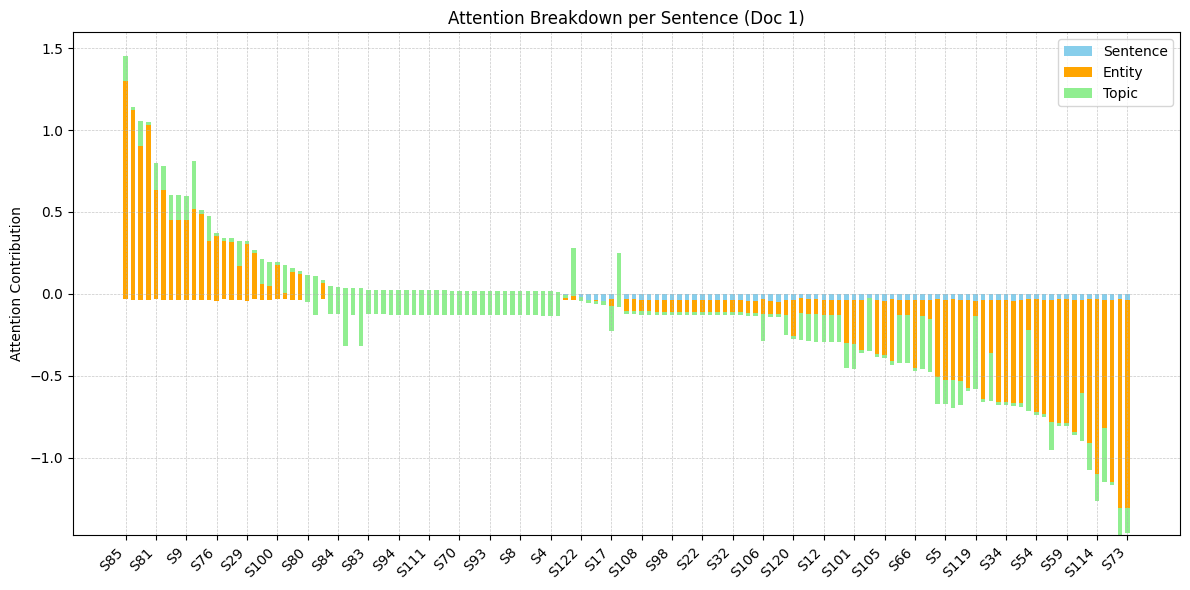

In [ ]:
plot_attention_breakdown(attention_data, doc_index=0, sentence_texts=sent_nodes, top_k=5, sort_by_score=True)

# graphs

## Heterogeneous Graph Structure

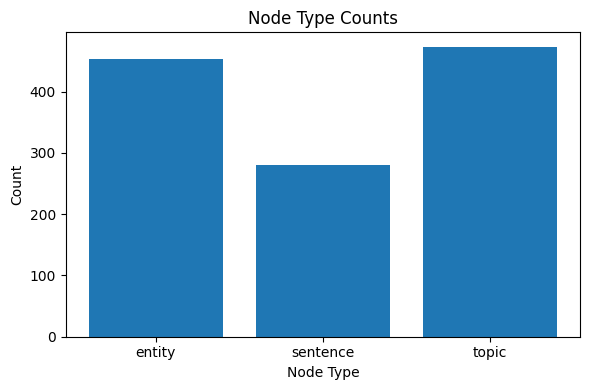

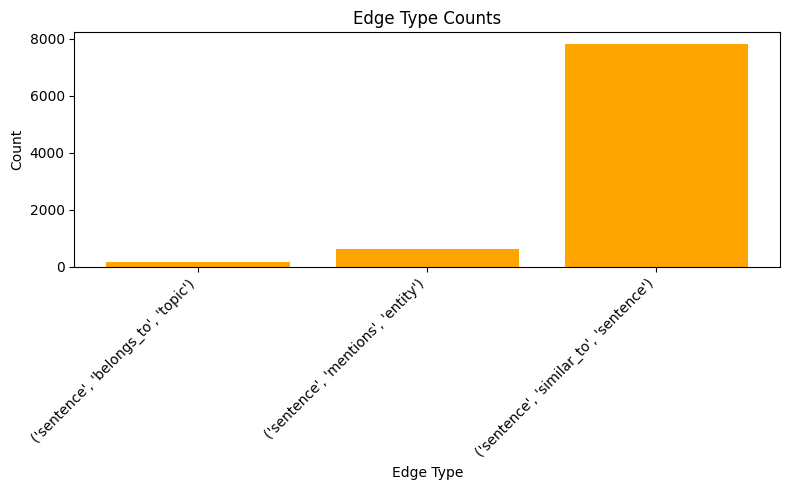

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import dgl

def visualize_graph_structure(g):
    """
    Plot bar charts of node and edge type counts.
    """
    node_counts = {ntype: g.num_nodes(ntype) for ntype in g.ntypes}
    edge_counts = {str(etype): g.num_edges(etype) for etype in g.canonical_etypes}

    # --- Node counts
    plt.figure(figsize=(6, 4))
    plt.bar(node_counts.keys(), node_counts.values())
    plt.title("Node Type Counts")
    plt.xlabel("Node Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # --- Edge counts
    plt.figure(figsize=(8, 5))
    plt.bar(edge_counts.keys(), edge_counts.values(), color='orange')
    plt.title("Edge Type Counts")
    plt.xlabel("Edge Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Call this after building your graph:
visualize_graph_structure(graph)


## Mini Graph Visualization with NetworkX

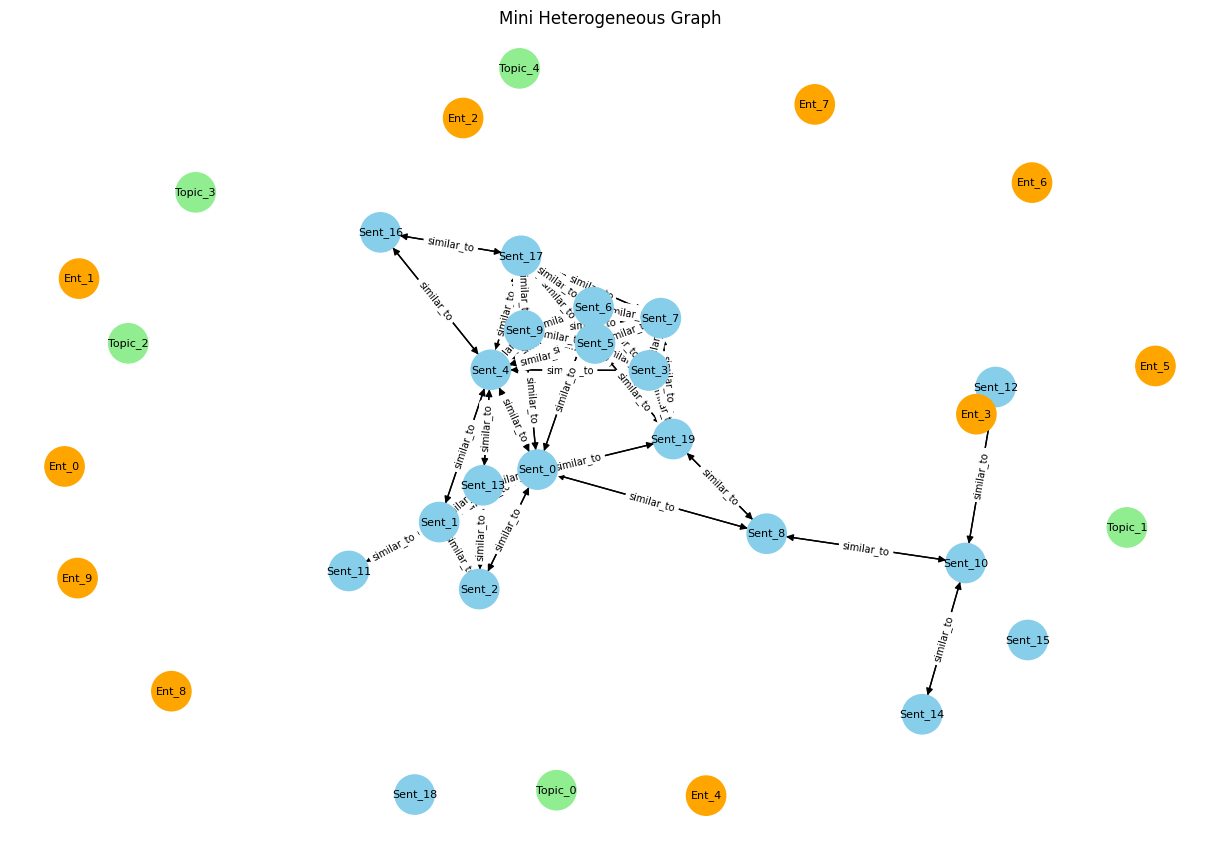

In [ ]:
import networkx as nx

def draw_mini_hetero_graph(g, sent_nodes, max_nodes=20):
    """
    Visualizes a mini graph with NetworkX extracted from the DGL graph.
    Only works well for small graphs (e.g. 10–20 nodes total).
    """
    G = nx.MultiDiGraph()

    # Limit sentence nodes for clarity
    node_ids = list(range(min(len(sent_nodes), max_nodes)))

    for i in node_ids:
        G.add_node(f"Sent_{i}", type='sentence')

    if 'entity' in g.ntypes:
        for i in range(min(g.num_nodes('entity'), 10)):
            G.add_node(f"Ent_{i}", type='entity')

    if 'topic' in g.ntypes:
        for i in range(min(g.num_nodes('topic'), 5)):
            G.add_node(f"Topic_{i}", type='topic')

    # Add edges
    for src, dst in zip(*g.edges(etype=('sentence', 'similar_to', 'sentence'))):
        if src.item() in node_ids and dst.item() in node_ids:
            G.add_edge(f"Sent_{src.item()}", f"Sent_{dst.item()}", label='similar_to')

    if ('sentence', 'mentions', 'entity') in g.canonical_etypes:
        src, dst = g.edges(etype=('sentence', 'mentions', 'entity'))
        for s, e in zip(src, dst):
            if s.item() in node_ids and e.item() < 10:
                G.add_edge(f"Sent_{s.item()}", f"Ent_{e.item()}", label='mentions')

    if ('sentence', 'belongs_to', 'topic') in g.canonical_etypes:
        src, dst = g.edges(etype=('sentence', 'belongs_to', 'topic'))
        for s, t in zip(src, dst):
            if s.item() in node_ids and t.item() < 5:
                G.add_edge(f"Sent_{s.item()}", f"Topic_{t.item()}", label='belongs_to')

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=0.6)
    node_colors = []
    for n in G.nodes(data=True):
        if n[1]['type'] == 'sentence':
            node_colors.append('skyblue')
        elif n[1]['type'] == 'entity':
            node_colors.append('orange')
        else:
            node_colors.append('lightgreen')

    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, font_size=8, arrows=True)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title("Mini Heterogeneous Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call this with your graph and sentence list
draw_mini_hetero_graph(graph, sent_nodes)


## Attention Score Heatmap per Sentence

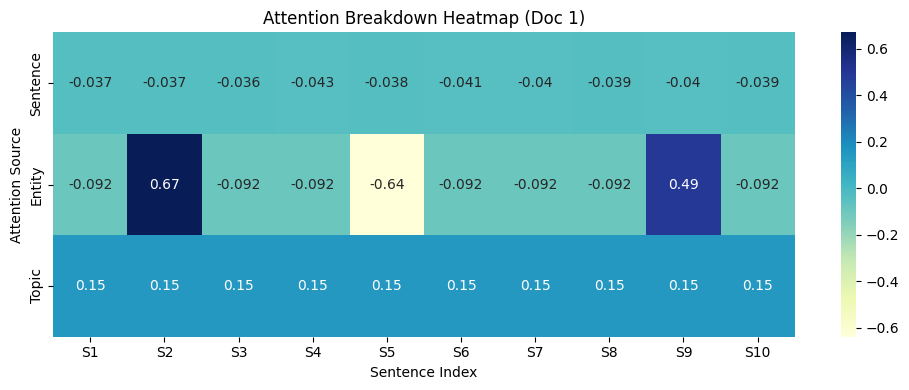

In [ ]:
import seaborn as sns
import numpy as np

def plot_attention_heatmap(attention_data, doc_index=0, top_k=10):
    doc = attention_data[doc_index]
    scores = np.stack([
        doc["sentence_scores"],
        doc["entity_scores"],
        doc["topic_scores"]
    ])

    scores = scores[:, :top_k]  # Limit to top-k for clarity
    labels = [f"S{i+1}" for i in range(top_k)]
    sources = ['Sentence', 'Entity', 'Topic']

    plt.figure(figsize=(10, 4))
    sns.heatmap(scores, annot=True, xticklabels=labels, yticklabels=sources, cmap='YlGnBu')
    plt.title(f"Attention Breakdown Heatmap (Doc {doc['doc_id'] + 1})")
    plt.xlabel("Sentence Index")
    plt.ylabel("Attention Source")
    plt.tight_layout()
    plt.show()

# Call with your saved attention_data
plot_attention_heatmap(attention_data, doc_index=0, top_k=10)


## Combine with Summary Output

In [ ]:
def print_summary_from_attention(attention_data, sent_nodes, doc_index=0, top_k=5):
    doc = attention_data[doc_index]
    sentence_scores = np.array(doc['sentence_scores']) + \
                      np.array(doc['entity_scores']) + \
                      np.array(doc['topic_scores'])

    top_idx = np.argsort(sentence_scores)[::-1][:top_k]
    print(f"\n📌 Top-{top_k} Summary Sentences for Document {doc['doc_id'] + 1}:\n")
    for rank, idx in enumerate(top_idx):
        print(f"{rank + 1}. {sent_nodes[idx]}")

# Call after inference
print_summary_from_attention(attention_data, sent_nodes, doc_index=0)



📌 Top-5 Summary Sentences for Document 1:

1. they also impose a model - dependent lower bound on @xmath150 , e.g. , @xmath151 for the type - ii 2hdm ( from our scan results ) , @xmath152 for the l2hdm@xcite , and @xmath153 for the nmssm @xcite .
2. on the other hand 
 , we find the contribution from quark / lepton - mediated loops can be safely neglected if @xmath127 in the type - ii 2hdm and the l2hdm .
3. since there is no @xmath194 coupling or @xmath195 coupling , @xmath0 must be associated with the other higgs bosons to contribute to the self energies .
4. the constraints from the cleo - iii limit on @xmath161 and the latest babar limits on @xmath162 .
5. for the type - ii 2hdm and the l2hdm , we consider the following constraints @xcite :    * theoretical constraints on @xmath136 from perturbativity , unitarity and requirements that the scalar potential is finit at large field values and contains no flat directions @xcite , which imply that @xmath137 * the constraints from the l